# Show plots of mutation locations throughout the genomes

In [1]:
%run "Header.ipynb"

In [2]:
import pileup
seq2pos2pileup = pileup.load()

In [3]:
import time
import skbio
from parse_sco import parse_sco

## Parameters of the diversity index: $p$ and $m$

See paper for description. These are currently copied from the diversity index notebook; ideally, should be loaded from the same place I guess.

In [4]:
m = 5

percentages = [50, 25, 10, 5, 2, 1, 0.5, 0.25, 0.1, 0.05]

p2pct = get_p2pct(percentages)
p2mincov = get_p2mincov(percentages, m)

# We skip 0.25% (since BACTERIA isn't sufficiently covered for it, although I guess we could show CAMP /
# BACTEROIDALES if desired) and we skip 0.1%, 0.05%, etc. since none of the 3 selected genomes are suff.
# covered for these percentages
percentages_were_gonna_use = percentages[:-2]

## Precompute the mutation / coverage data for each genome for each $p$

This doesn't save time if we're just rerunning this notebook once, but it makes it __a lot__ easier to repeatedly redo the visualization part of things -- which is really useful in tweaking the figure to make it pretty (moving around labels/legends, changing sizes, etc.)

In [5]:
seq2p2within_gene_muts = {}
seq2p2intergenic_muts = {}
seq2p2sufficiently_covered_positions = {}
seq2p2insufficiently_covered_positions = {}

print(f"Percentages (values of p we're going to use): {percentages_were_gonna_use}")
for si, seq in enumerate(SEQS):
    print(f"On seq {seq}...")

    t1 = time.time()
    print("\tRetrieving sequence-level data...")
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    sequence = str(skbio.DNA.read(f"../seqs/{seq}.fasta"))
    positions = range(1, seq2len[seq] + 1)
    pos_to_genes = get_parent_gene_info_of_many_positions(1, seq2len[seq], genes_df)
    t2 = time.time()
    print(f"\tDone retrieving data. Time taken: {t2 - t1:,.2f} sec.")
    
    p2within_gene_muts = {p: [] for p in percentages_were_gonna_use}
    p2intergenic_muts = {p: [] for p in percentages_were_gonna_use}
    p2sufficiently_covered_positions = {p: [] for p in percentages_were_gonna_use}
    p2insufficiently_covered_positions = {p: [] for p in percentages_were_gonna_use}
    
    print("\tGoing through positions...")
    for pos in positions:
        if pos % 1e5 == 0:
            print(f"\t\tOn position {pos:,} / {seq2len[seq]:,} bp.")
        cov = pileup.get_cov(seq2pos2pileup[seq][pos])
        for p in percentages_were_gonna_use:
            if cov >= p2mincov[p]:
                
                if pileup.naively_call_mutation(seq2pos2pileup[seq][pos], p2pct[p]):
                    num_genes = len(pos_to_genes[pos])
                    if num_genes == 0:
                        p2intergenic_muts[p].append(pos)
                    else:
                        p2within_gene_muts[p].append(pos)
                        
                p2sufficiently_covered_positions[p].append(pos)
            else:
                p2insufficiently_covered_positions[p].append(pos)
                
    seq2p2within_gene_muts[seq] = p2within_gene_muts
    seq2p2intergenic_muts[seq] = p2intergenic_muts
    seq2p2sufficiently_covered_positions[seq] = p2sufficiently_covered_positions
    seq2p2insufficiently_covered_positions[seq] = p2insufficiently_covered_positions

Percentages (values of p we're going to use): [50, 25, 10, 5, 2, 1, 0.5, 0.25]
On seq edge_6104...
	Retrieving sequence-level data...
	Done retrieving data. Time taken: 2.09 sec.
	Going through positions...
		On position 100,000 / 1,289,244 bp.
		On position 200,000 / 1,289,244 bp.
		On position 300,000 / 1,289,244 bp.
		On position 400,000 / 1,289,244 bp.
		On position 500,000 / 1,289,244 bp.
		On position 600,000 / 1,289,244 bp.
		On position 700,000 / 1,289,244 bp.
		On position 800,000 / 1,289,244 bp.
		On position 900,000 / 1,289,244 bp.
		On position 1,000,000 / 1,289,244 bp.
		On position 1,100,000 / 1,289,244 bp.
		On position 1,200,000 / 1,289,244 bp.
On seq edge_1671...
	Retrieving sequence-level data...
	Done retrieving data. Time taken: 1.04 sec.
	Going through positions...
		On position 100,000 / 2,153,394 bp.
		On position 200,000 / 2,153,394 bp.
		On position 300,000 / 2,153,394 bp.
		On position 400,000 / 2,153,394 bp.
		On position 500,000 / 2,153,394 bp.
		On position

On seq edge_6104 (length 1,289,244 bp)...
On seq edge_1671 (length 2,153,394 bp)...
On seq edge_2358 (length 2,806,161 bp)...


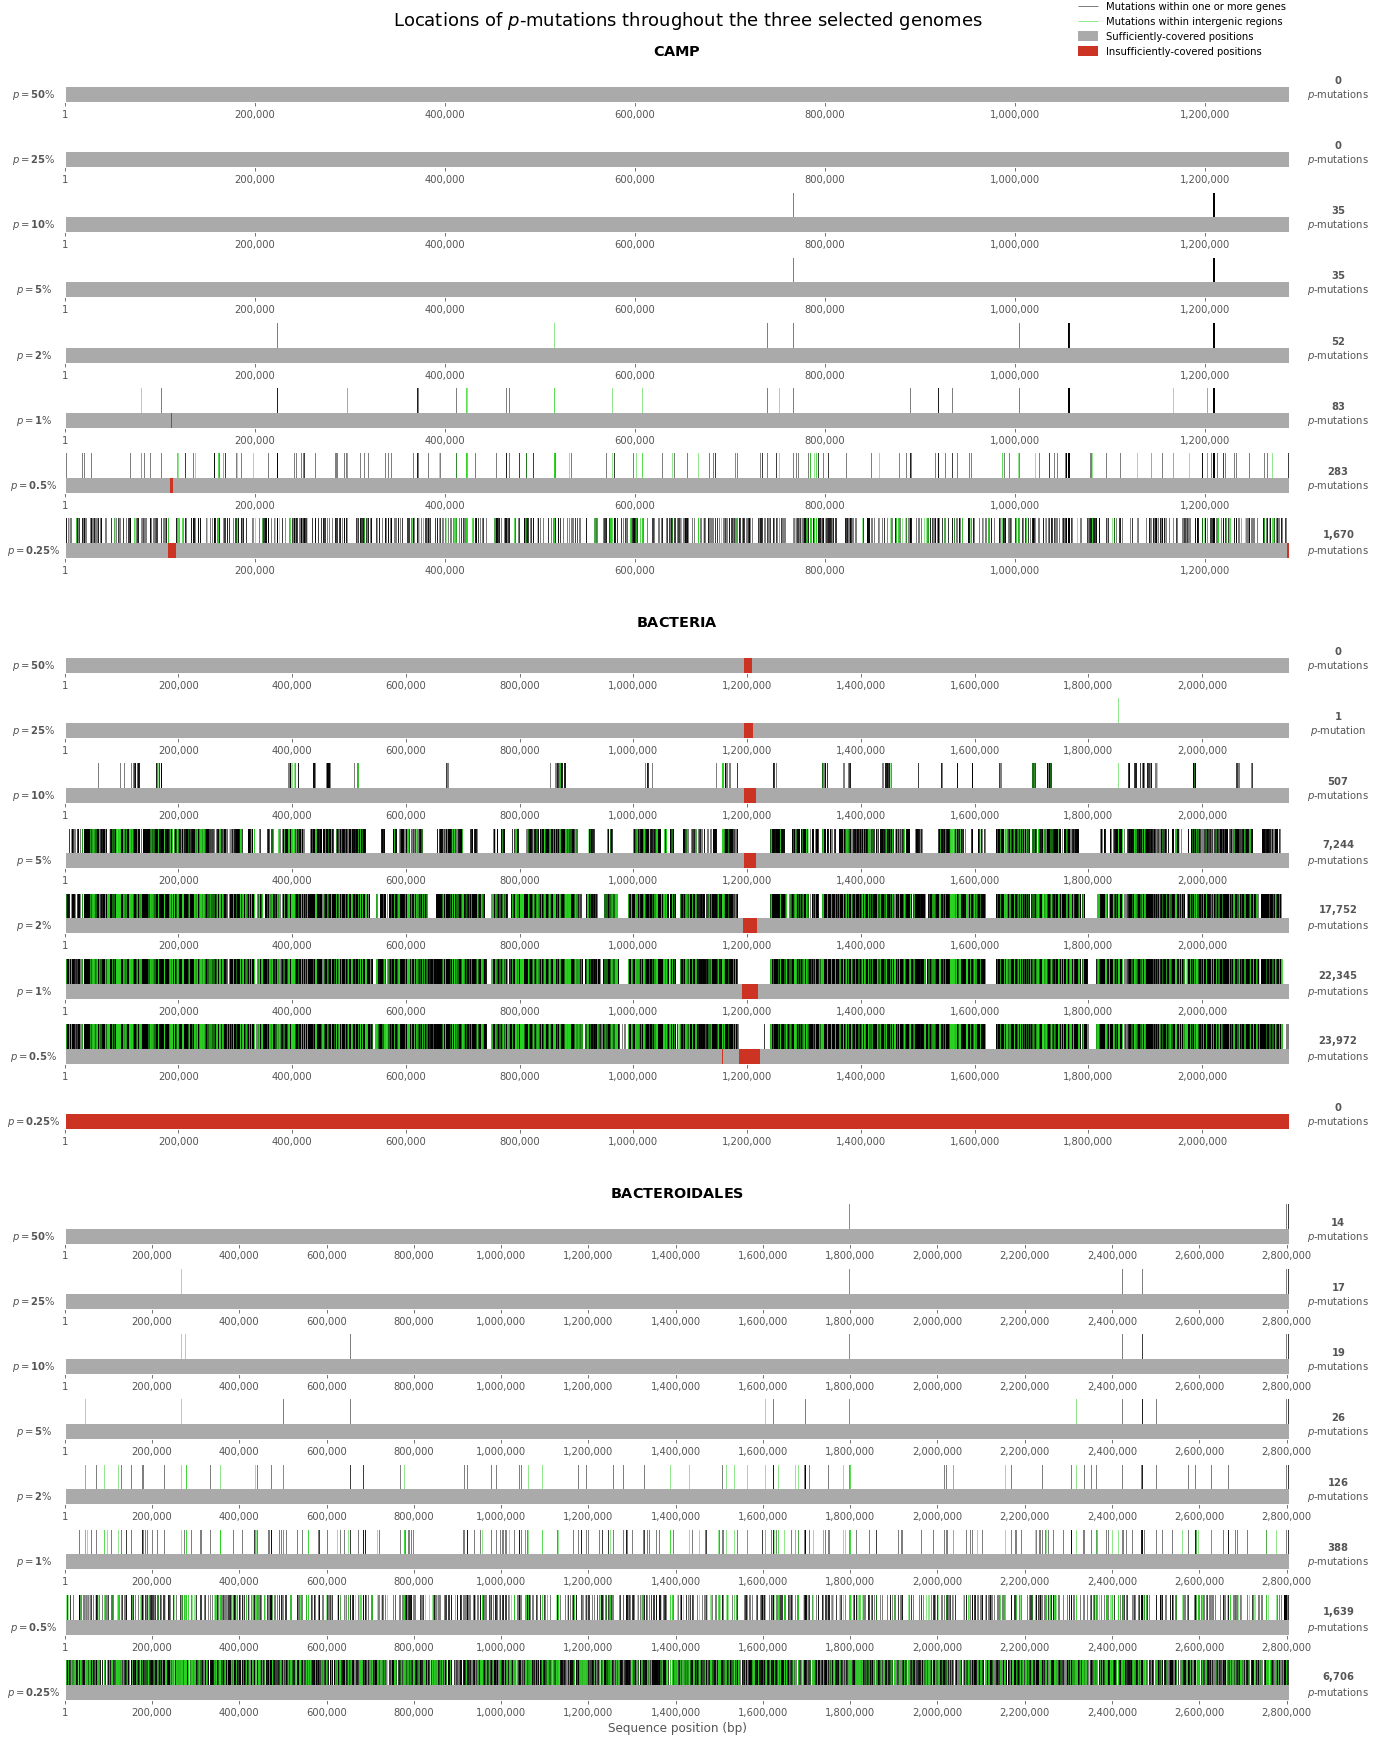

In [6]:
num_rows = 3 * len(percentages_were_gonna_use)
# For some reason, when I *don't* use constrained_layout, there's a ton of extra whitespace at the top of the
# figure. No idea what causes it in this plot specifically.
fig, ax = pyplot.subplots(num_rows, 1, gridspec_kw={"hspace": 1.5}, constrained_layout=True)

YMAX = 0.25

for si, seq in enumerate(SEQS):
    print(f"On seq {seq} (length {seq2len[seq]:,} bp)...")
    for pi, p in enumerate(percentages_were_gonna_use):
        
        ax_idx = (si * len(percentages_were_gonna_use)) + pi
        
        #print(f"\tOn percentage p = {p}%...", end=" ")
        #print(f"axis index: {ax_idx} / {num_rows - 1}")
        
        within_gene_muts = seq2p2within_gene_muts[seq][p]
        intergenic_muts = seq2p2intergenic_muts[seq][p]
        num_p_muts = len(within_gene_muts) + len(intergenic_muts)
        sufficiently_covered_positions = seq2p2sufficiently_covered_positions[seq][p]
        insufficiently_covered_positions = seq2p2insufficiently_covered_positions[seq][p]

        # We use the first ax for BACTERIA because (as of writing) CAMP has no insufficiently covered
        # positions for the top value of p, so no insufficient position info shows up in the legend.
        # BACTERIA, on the other hand, has cov drops -- which actually helps cover all cases we
        # show in the legend in this case.
        if seq == "edge_1671" and pi == 0:
            wgm_label = "Mutations within one or more genes"
            igm_label = "Mutations within intergenic regions"
            sc_label = "Sufficiently-covered positions"
            ic_label = "Insufficiently-covered positions"
        else:
            wgm_label = igm_label = sc_label = ic_label = None

        if ax_idx == num_rows - 1:
            ax[ax_idx].set_xlabel("Sequence position (bp)")

        # Draw vertical lines indicating called p-mutations
        # We make it a point to draw these *before* the horizontal lines so that the horizontal lines
        # are drawn on top
        ax[ax_idx].vlines(within_gene_muts, 0, YMAX, color="#000000", linewidth=0.5, label=wgm_label)
        ax[ax_idx].vlines(intergenic_muts, 0, YMAX, color=cp2color[4], linewidth=0.5, label=igm_label)
        
        # Draw horizontal lines indicating sufficiently and insufficiently-covered positions
        for type_of_positions, color, label in (
            (sufficiently_covered_positions, "#aaaaaa", sc_label),
            (insufficiently_covered_positions, "#cc3322", ic_label)
        ):
            if len(type_of_positions) > 0:
                runs = convert_to_runs(type_of_positions)
                run_starts = [r[0] for r in runs]
                run_ends = [r[1] for r in runs]
                ax[ax_idx].hlines(
                    [0] * len(run_starts), run_starts, [s + 1 for s in run_ends],
                    color=color, linewidth=30, label=label
                )
                debug_runs = False
                if debug_runs:
                    if color == "#aaaaaa":
                        prefix = "Sufficiently-covered"
                    else:
                        prefix = "Insufficiently-covered"
                    print(f"\t{prefix} runs for {seq} at p = {p}%:")
                    print(f"\t\tStarts: {run_starts}")
                    print(f"\t\tEnds: {run_ends}")

        if pi == 0:
            ax[ax_idx].set_title("\n\n" + r"$\bf{" + seq2name[seq] + "}$")
        
        leftlabel = r"$p = \bf{" + str(p) + "}$%"
        # Use {,} to remove unneeded spaces around thousands separators, which are automatically
        # added due to MathTeX stuff:
        rightlabel = r"$\bf{" + f"{num_p_muts:,}".replace(",", "{,}") + "}$\n$p$-mutation"
        
        # Use nice grammar, since BACTERIA at p=25% has exactly one p-mutation as of writing :P
        if num_p_muts != 1:
            rightlabel += "s"
            
        # We can position the left and right labels (adjacent to the y-axis) using ax.text(),
        # which defaults to data coordinates -- so the x and y values here are comparable to the x and y
        # values we used for the mutation positions, blocks of sufficiently/insufficiently covered positions,
        # etc. above.
        loffset = seq2len[seq] * 0.025
        roffset = seq2len[seq] * 0.04
        ax[ax_idx].text(-loffset, 0.03, leftlabel, ha="center", color="#555555")
        ax[ax_idx].text(seq2len[seq] + roffset, 0.03, rightlabel, ha="center", color="#555555")
        
        # Hide y-axis numbers / ticks, since they don't really have meaning in this plot:
        # https://stackoverflow.com/a/2176591
        ax[ax_idx].set_yticks([])

        ax[ax_idx].set_ylim(0, YMAX)
        
        # Crude method of forcing the x ticks to include 1 bp (the start of each sequence). Could be
        # generalized to each sequence, since this doesn't vary between percentage values.
        xticks = [1]
        curr_x_pos = 200000
        while curr_x_pos <= seq2len[seq]:
            xticks.append(curr_x_pos)
            curr_x_pos += 200000
        ax[ax_idx].set_xticks(xticks)
        
        # For some reason the use_thousands_separator() function I defined in the header notebook breaks
        # here? I get a weird error about numpy numbers not being convertable to integers or something.
        # However, the following approach (similar to that used in the diversity indices ntbk) does the same
        # thing and works fine, far as I can tell.
        ax[ax_idx].xaxis.set_major_formatter("{x:,.0f}")
        
        # the purpose of setting the upper x limit is to avoid unsightly things where mutations near the
        # end of a genome "go beyond" the gray/red bars (this happens in BACTEROIDALES esp as of writing).
        #
        # We include up to 1 above the seq len because each "block" of (in)sufficiently covered positions
        # ranges from [block start in 1-indexed coords, block end in 1-indexed coords + 1] so that blocks
        # of 1 position technically take up space. Think this is reasonable, although granted: 1-pos-length
        # blocks really aren't visible at this range.
        ax[ax_idx].set_xlim(1, seq2len[seq] + 1)

        # Make the plot white: https://stackoverflow.com/a/4708018
        ax[ax_idx].patch.set_facecolor("None")
        ax[ax_idx].patch.set_edgecolor("None")
        ax[ax_idx].patch.set_alpha(0)
    
legend = fig.legend(loc=(0.78, 0.965), facecolor="white", edgecolor="white")

# Ignore linewidth used in the figure legends for position markers: https://stackoverflow.com/a/9707180
# This is because the thick line width for the insuff-covered positions ends up being drawn "over"
# the suff-covered positions' symbol in the legend, which looks gross. Note that we *do* want to keep the
# line widths for the mutation position symbols, to disambiguate things.
# In order to distinguish between these handles in the legend, we just use the order of the handles...
# because from some testing, the get_label(), _label, etc. methods/params of the legend handles don't seem
# to return anything useful ._.
for li, legobj in enumerate(legend.legendHandles):
    if li > 1:
        legobj.set_linewidth(10)
        
fig.set_size_inches(19, 24)
fig.suptitle("Locations of $p$-mutations throughout the three selected genomes", x=0.5, y=1, fontsize=18)
fig.savefig("figs/mutation-locations.png", bbox_inches="tight")